In [1]:
import time
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import datetime
import matplotlib.dates as mdates
from collections import deque
import numpy as np

import serial
import serial.tools.list_ports
import re

# How many sensor samples we want to store
HISTORY_SIZE = 2500

# Pause re-sampling the sensor and drawing for INTERVAL seconds
INTERVAL = 0.01


In [2]:
serialport = None

def get_imu_data():
    global serialport
    if not serialport:
        ports = list(serial.tools.list_ports.comports())
        for p in ports:
            if "ACM" in p.device:
                PORT = p.device
        # open serial port
        serialport = serial.Serial(PORT, 57600, timeout=0.1)
        # check which port was really used
        print("Opened", serialport.name)
        # Flush input
        time.sleep(3)
        serialport.readline()

    # Poll the serial port
    line = str(serialport.readline(), 'utf-8')
    if not line:
        return None
    #print(line)
    if not "Uni:" in line:
        return None
    vals = line.replace("Uni:", "").strip().split(',')
    #print(vals)
    if len(vals) != 9:
        return None
    try:
        vals = [float(i) for i in vals]
    except ValueError:
        return None
    #print(vals)
    return vals

for _ in range(20):
    print(get_imu_data())

Opened /dev/ttyACM0
None
None
[0.627, -0.081, 9.589, 0.02, 0.01, 0.008, -2.294, 18.349, -16.147]
None
[0.639, -0.041, 9.555, 0.021, 0.01, 0.01, -2.018, 20.0, -15.505]
None
[0.622, -0.057, 9.534, 0.02, 0.008, 0.007, -2.018, 19.174, -15.963]
None
[0.654, 0.029, 9.653, 0.043, 0.012, 0.01, -1.743, 19.725, -16.697]
None
[0.649, 0.002, 9.689, 0.023, 0.007, 0.009, -2.018, 18.532, -16.789]
None
[0.656, -0.012, 9.538, 0.019, 0.008, 0.01, -1.468, 18.349, -15.78]
None
[0.642, -0.06, 9.51, 0.021, 0.006, 0.011, -1.743, 20.55, -15.321]
None
[0.615, -0.045, 9.562, 0.021, 0.009, 0.013, -2.477, 19.266, -16.697]
None
[0.637, -0.065, 9.577, 0.019, 0.009, 0.011, -1.651, 18.716, -16.422]
None


# Magnetometer data capture

/tmp/ipykernel_26471/880064467.py:46: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  anim = FuncAnimation(fig, animate)


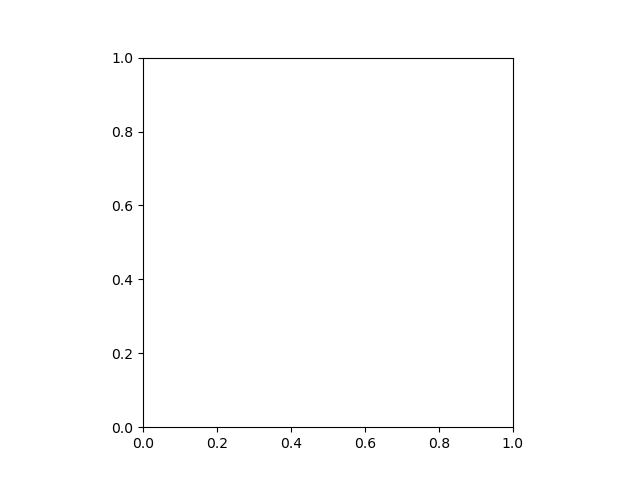

In [3]:
# Deque for axes
mag_x = deque(maxlen=HISTORY_SIZE)
mag_y = deque(maxlen=HISTORY_SIZE)
mag_z = deque(maxlen=HISTORY_SIZE)

fig, ax = plt.subplots(1, 1)
ax.set_aspect(1)

# close port in case its open
if serialport:
    try:
        serialport.close()
    except NameError:
        pass

serialport = None
anim = None

def onClick(event):
    anim.event_source.stop()
    
def animate(i):
    for _ in range(30):
        ret = get_imu_data()
        if not ret:
            continue
        x, y, z = ret[6:9]
        mag_x.append(x)
        mag_y.append(y)
        mag_z.append(z)

    # Clear all axis
    ax.cla()

    # Display the sub-plots
    ax.scatter(mag_x, mag_y, color='r')
    ax.scatter(mag_y, mag_z, color='g')
    ax.scatter(mag_z, mag_x, color='b')
    
    if len(mag_x) == HISTORY_SIZE:
        anim.event_source.stop()
    # Pause the plot for INTERVAL seconds 
    plt.pause(INTERVAL)

fig.canvas.mpl_connect('button_press_event', onClick)    
anim = FuncAnimation(fig, animate)

In [ ]:
min_x = min(mag_x)
max_x = max(mag_x)
min_y = min(mag_y)
max_y = max(mag_y)
min_z = min(mag_z)
max_z = max(mag_z)

print("X range: ", min_x, max_x)
print("Y range: ", min_y, max_y)
print("Z range: ", min_z, max_z)

mag_calibration = [ (max_x + min_x) / 2, (max_y + min_y) / 2, (max_z + min_z) / 2]
print("Final calibration in uTesla:", mag_calibration)

cal_mag_x = [x - mag_calibration[0] for x in mag_x]
cal_mag_y = [y - mag_calibration[1] for y in mag_y]
cal_mag_z = [z - mag_calibration[2] for z in mag_z]

fig, ax = plt.subplots(1, 1)
ax.set_aspect(1)

# Clear all axis
ax.cla()

# Display the now calibrated data
ax.scatter(cal_mag_x, cal_mag_y, color='r')
ax.scatter(cal_mag_y, cal_mag_z, color='g')
ax.scatter(cal_mag_z, cal_mag_x, color='b')
fig.show()

# Gyroscope offset calibration

In [ ]:
print("Put down the board and do not touch or move it!")
for s in range(3, 0, -1):
    print(s, end='...')
    time.sleep(1)
print("COLLECTING GYRO DATA")

# close port in case its open
if serialport:
    try:
        serialport.close()
    except NameError:
        pass

serialport = None

# Deque for axes
gyro_x = deque(maxlen=HISTORY_SIZE//10)
gyro_y = deque(maxlen=HISTORY_SIZE//10)
gyro_z = deque(maxlen=HISTORY_SIZE//10)
while len(gyro_x) < (HISTORY_SIZE//10):
    ret = get_imu_data()
    #print(ret)
    if not ret:
        continue
    x, y, z = ret[3:6]
    gyro_x.append(x)
    gyro_y.append(y)
    gyro_z.append(z)

for _ in range(3):
    gyro_x.popleft()
    gyro_y.popleft()
    gyro_z.popleft()

min_x = min(gyro_x)
max_x = max(gyro_x)
min_y = min(gyro_y)
max_y = max(gyro_y)
min_z = min(gyro_z)
max_z = max(gyro_z)

print("Gyro X range: ", min_x, max_x)
print("Gyro Y range: ", min_y, max_y)
print("Gyro Z range: ", min_z, max_z)

gyro_calibration = [ (max_x + min_x) / 2, (max_y + min_y) / 2, (max_z + min_z) / 2]
print("Final calibration in rad/s:", gyro_calibration)

fig, (uncal, cal) = plt.subplots(2, 1)

# Clear all axis
uncal.cla()
t = np.linspace(0, len(gyro_x), len(gyro_x))
# plot uncalibrated data
uncal.plot(t, gyro_x, color='r')
uncal.plot(t, gyro_y, color='g')
uncal.plot(t, gyro_z, color='b')
uncal.title.set_text("Uncalibrated Gyro")
uncal.set(ylabel='Radians/s')
# plot calibrated data
cal.plot(t, [x - gyro_calibration[0] for x in gyro_x], color='r')
cal.plot(t, [y - gyro_calibration[1] for y in gyro_y], color='g')
cal.plot(t, [z - gyro_calibration[2] for z in gyro_z], color='b')
cal.title.set_text("Calibrated Gyro")
cal.set(ylabel='Radians/s')

fig.tight_layout()
fig.show()
serialport.close()